In [1]:
import os
from pathlib import Path
import itertools
from datetime import datetime

import numpy as np
from obspy import read_inventory

from flovopy.asl.map import topo_map  # your function
from flovopy.core.mvo import dome_location

# --- Project inputs you already have somewhere else ---
PROJECTDIR = "/Users/GlennThompson/Dropbox/BRIEFCASE/SSADenver"
LOCALPROJECTDIR = "/Users/GlennThompson/work/PROJECTS/SSADenver_local"
OUTPUT_DIR = f"{LOCALPROJECTDIR}/asl_notebooks"

INVENTORY_XML = f"{PROJECTDIR}/MV.xml"
DEM_TIF_FOR_BMAP = f"{PROJECTDIR}/channel_finder/02_dem_flipped_horizontal.tif"
DEM_TIF_FOR_BMAP = Path("/Users/glennthompson/Dropbox/PROFESSIONAL/DATA/wadgeDEMs/auto_crs_fit_v2/wgs84_s0.4_3_clean.tif")

# I/O
INPUT_DIR = f"{PROJECTDIR}/ASL_inputs/biggest_pdc_events"
OUTPUT_DIR = f"{LOCALPROJECTDIR}/asl_notebooks"
INVENTORY_XML = f"{PROJECTDIR}/MV.xml"

# Grid/data options
'''
GRID_KIND = "streams"   # Montserrat: stream-based NodeGrid
CHANNELS_DIR = f"{PROJECTDIR}/channel_finder/channels_csv"
CHANNELS_STEP_M = 100.0
CHANNELS_DEM_TIF = f"{PROJECTDIR}/channel_finder/02_dem_flipped_horizontal.tif"
'''

NODE_SPACING_M = 50
DIST_MODE = "2d"        # include elevation\
GLOBAL_CACHE = f"{LOCALPROJECTDIR}/asl_global_cache"
OUTPUT_DIR = GLOBAL_CACHE

# Montserrat default region (lon_min, lon_max, lat_min, lat_max)
REGION_DEFAULT = (-62.255, -62.135, 16.66, 16.84)

# Load inventory once (optional)
try:
    INV = read_inventory(INVENTORY_XML)
except Exception:
    INV = None

In [2]:
# === “Experiment” grid: 10x15 km, 10 m spacing, 7 km circular mask ===

from flovopy.asl.grid import make_grid, _meters_per_degree  # _meters_per_degree is fine to import

# (Assumes these exist from your earlier cells)
# PROJECTDIR, OUTPUT_DIR, INVENTORY_XML, DEM_TIF_FOR_BMAP, REGION

# 1) Build regular grid centered at the dome (flat; no DEM sampling needed for the mask)
GRID_SIZE_LAT_M = 10_000   # 10 km N–S
GRID_SIZE_LON_M = 15_000   # 15 km E–W
NODE_SPACING_M  = 10       # 50 m nodes
MASK_RADIUS_KM  = 7.5      # 7.5 km circular mask

# 1) Build grid *with DEM* so we can mask by sea level (0.0 m)
#dem_spec = ("geotiff", {"path": DEM_TIF_FOR_BMAP, "tag": os.path.basename(DEM_TIF_FOR_BMAP)})
dem_spec = ("pygmt", {"resolution": "01s"})  # or "01s"
grid = make_grid(
    center_lat=dome_location["lat"],
    center_lon=dome_location["lon"],
    node_spacing_m=NODE_SPACING_M,
    grid_size_lat_m=GRID_SIZE_LAT_M,
    grid_size_lon_m=GRID_SIZE_LON_M,
    dem=dem_spec,
)
print(f"[GRID] {grid.nlat}x{grid.nlon} nodes ({grid.gridlat.size} total)  spacing={NODE_SPACING_M} m")

# 2) Circular mask (≤ 7 km from dome center) using local ENU approximation
m_per_deg_lat, m_per_deg_lon = _meters_per_degree(grid.centerlat)
dlat_m = (grid.gridlat - grid.centerlat) * m_per_deg_lat
dlon_m = (grid.gridlon - grid.centerlon) * m_per_deg_lon
dist_m = np.hypot(dlat_m, dlon_m)
mask_radius = dist_m <= (MASK_RADIUS_KM * 1000.0)
kept_circle = int(mask_radius.sum())
print(f"[CIRCLE MASK] kept {kept_circle}/{grid.gridlat.size} nodes ({100*kept_circle/grid.gridlat.size:.1f}%)")

# 3) Land mask from DEM (elevation > 0.0 m)
land_mask = grid.apply_land_mask_from_dem(sea_level=0.0)
kept_land = int(land_mask.sum())
print(f"[LAND MASK] kept {kept_land}/{grid.gridlat.size} nodes ({100*kept_land/grid.gridlat.size:.1f}%)")

# 4) Combine masks and apply
combined = mask_radius & land_mask
grid.apply_mask_boolean(combined)
kept = int(combined.sum())
print(f"[MASK] kept {kept}/{grid.gridlat.size} nodes ({100*kept/grid.gridlat.size:.1f}%) within {MASK_RADIUS_KM} km and above sea level")


[GRID] 1001x1501 nodes (1502501 total)  spacing=10 m
[CIRCLE MASK] kept 1381057/1502501 nodes (91.9%)
[LAND MASK] kept 678937/1502501 nodes (45.2%)
[MASK] kept 678909/1502501 nodes (45.2%) within 7.5 km and above sea level


/Users/glennthompson/Developer/flovopy/flovopy/asl/map.py:185: RasterioDeprecationWarning: statistics() will be removed in 2.0.0. Please switch to stats().
  stats = src.statistics(1) if hasattr(src, "statistics") else None
makecpt [WARNING]: Without inc in -T option, -Z has no effect (ignored)
/opt/anaconda3/envs/flovopy_plus/lib/python3.12/site-packages/obspy/core/inventory/network.py:321: UserWarning: Found more than one matching channel metadata. Returning first.
  warnings.warn(msg)


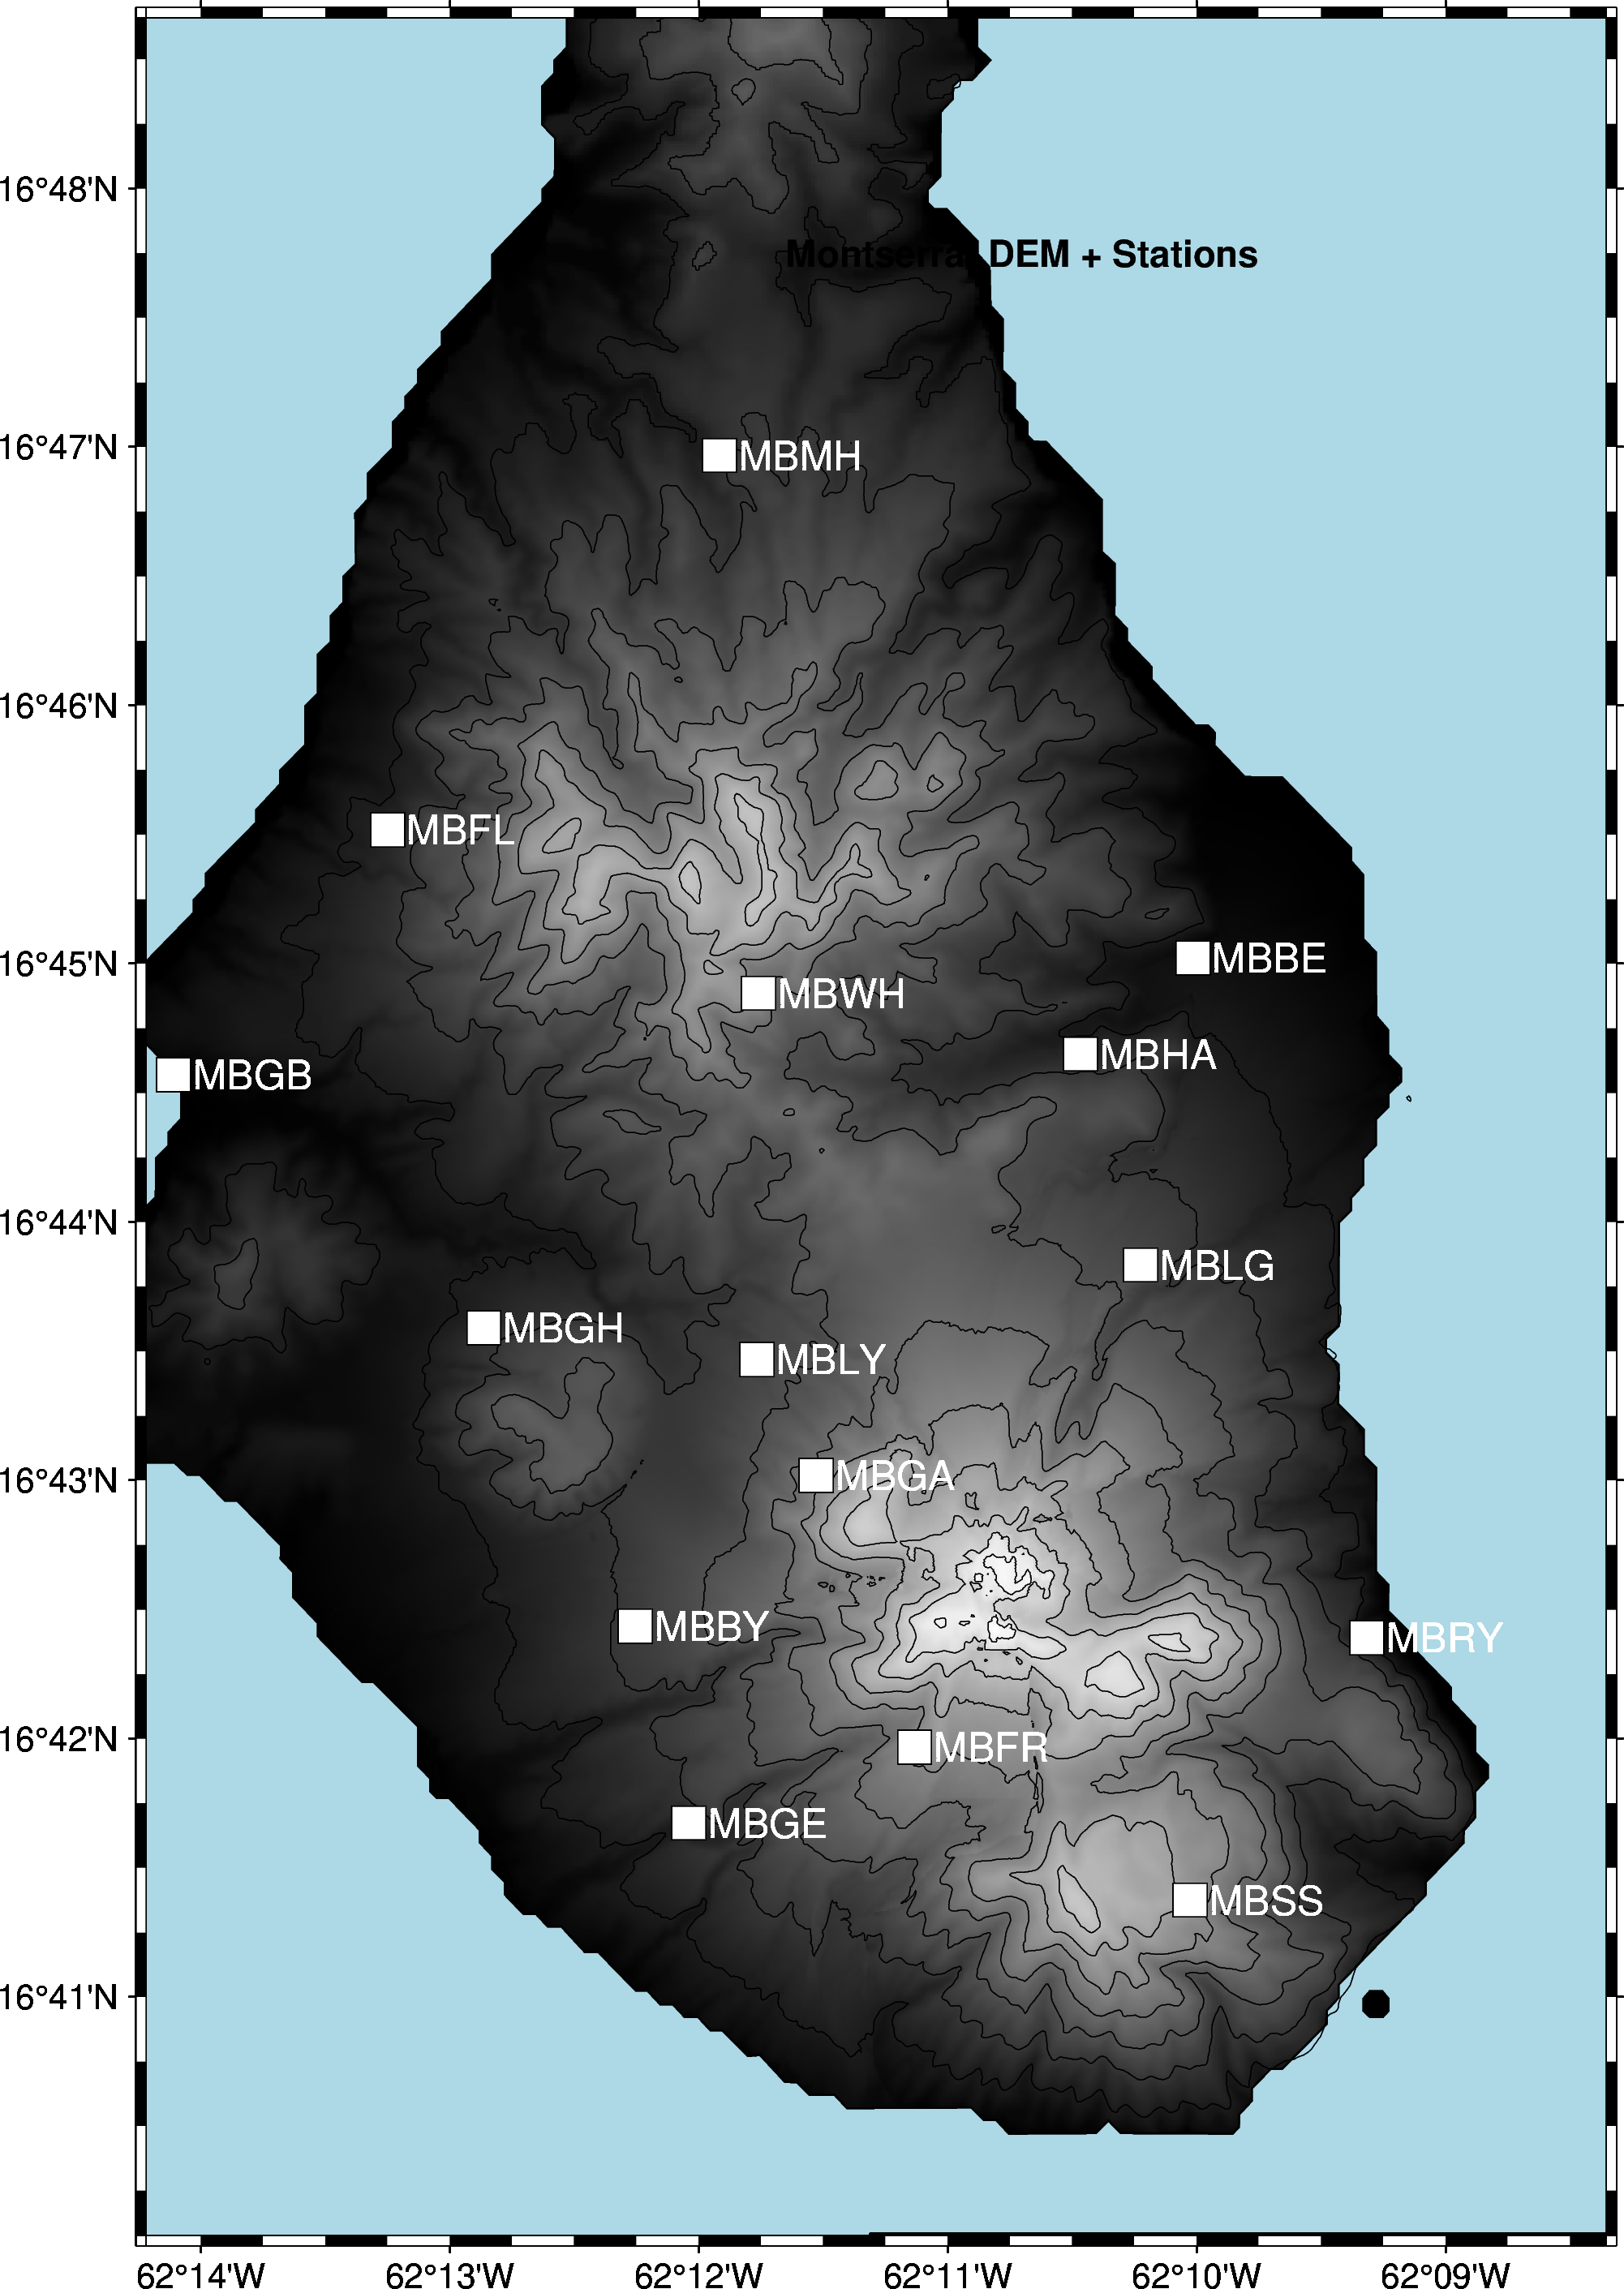

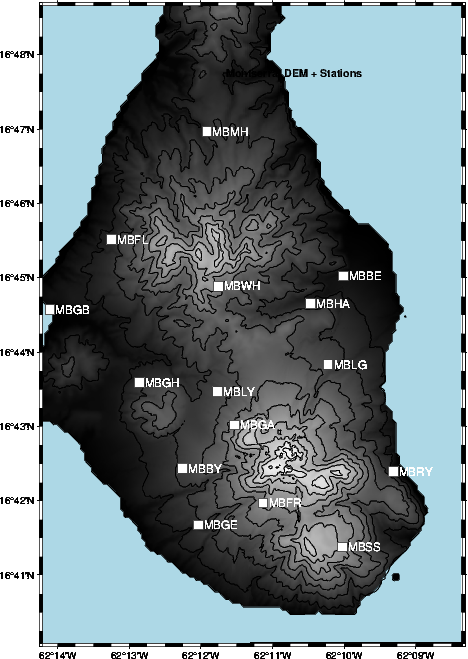

In [ ]:

# 5) Plot with stations overlaid (using your GeoTIFF basemap + REGION)
try:
    inv = read_inventory(INVENTORY_XML)
except Exception:
    inv = None

topo_kw = {
    "show": True,
    "inv": inv,
    "add_labels": True,
    "topo_color": False,
    "cmap": None,
    "add_shading": False,
    # "region": REGION,
    "zoom_level": 0,
    "dem_tif": DEM_TIF_FOR_BMAP,  # basemap shading from your GeoTIFF
    #"dem_tif": None,
    "figsize": 6.0,
    "title": "Montserrat DEM + Stations",
    "frame": True,
    "region": None,
    #"land_fill": "green",
    #"outfile": str(Path(OUTPUT_DIR) / "topomap.png"),
}

# Call topo_map with dictionary expansion
topo_map(**topo_kw);


makecpt [WARNING]: Without inc in -T option, -Z has no effect (ignored)


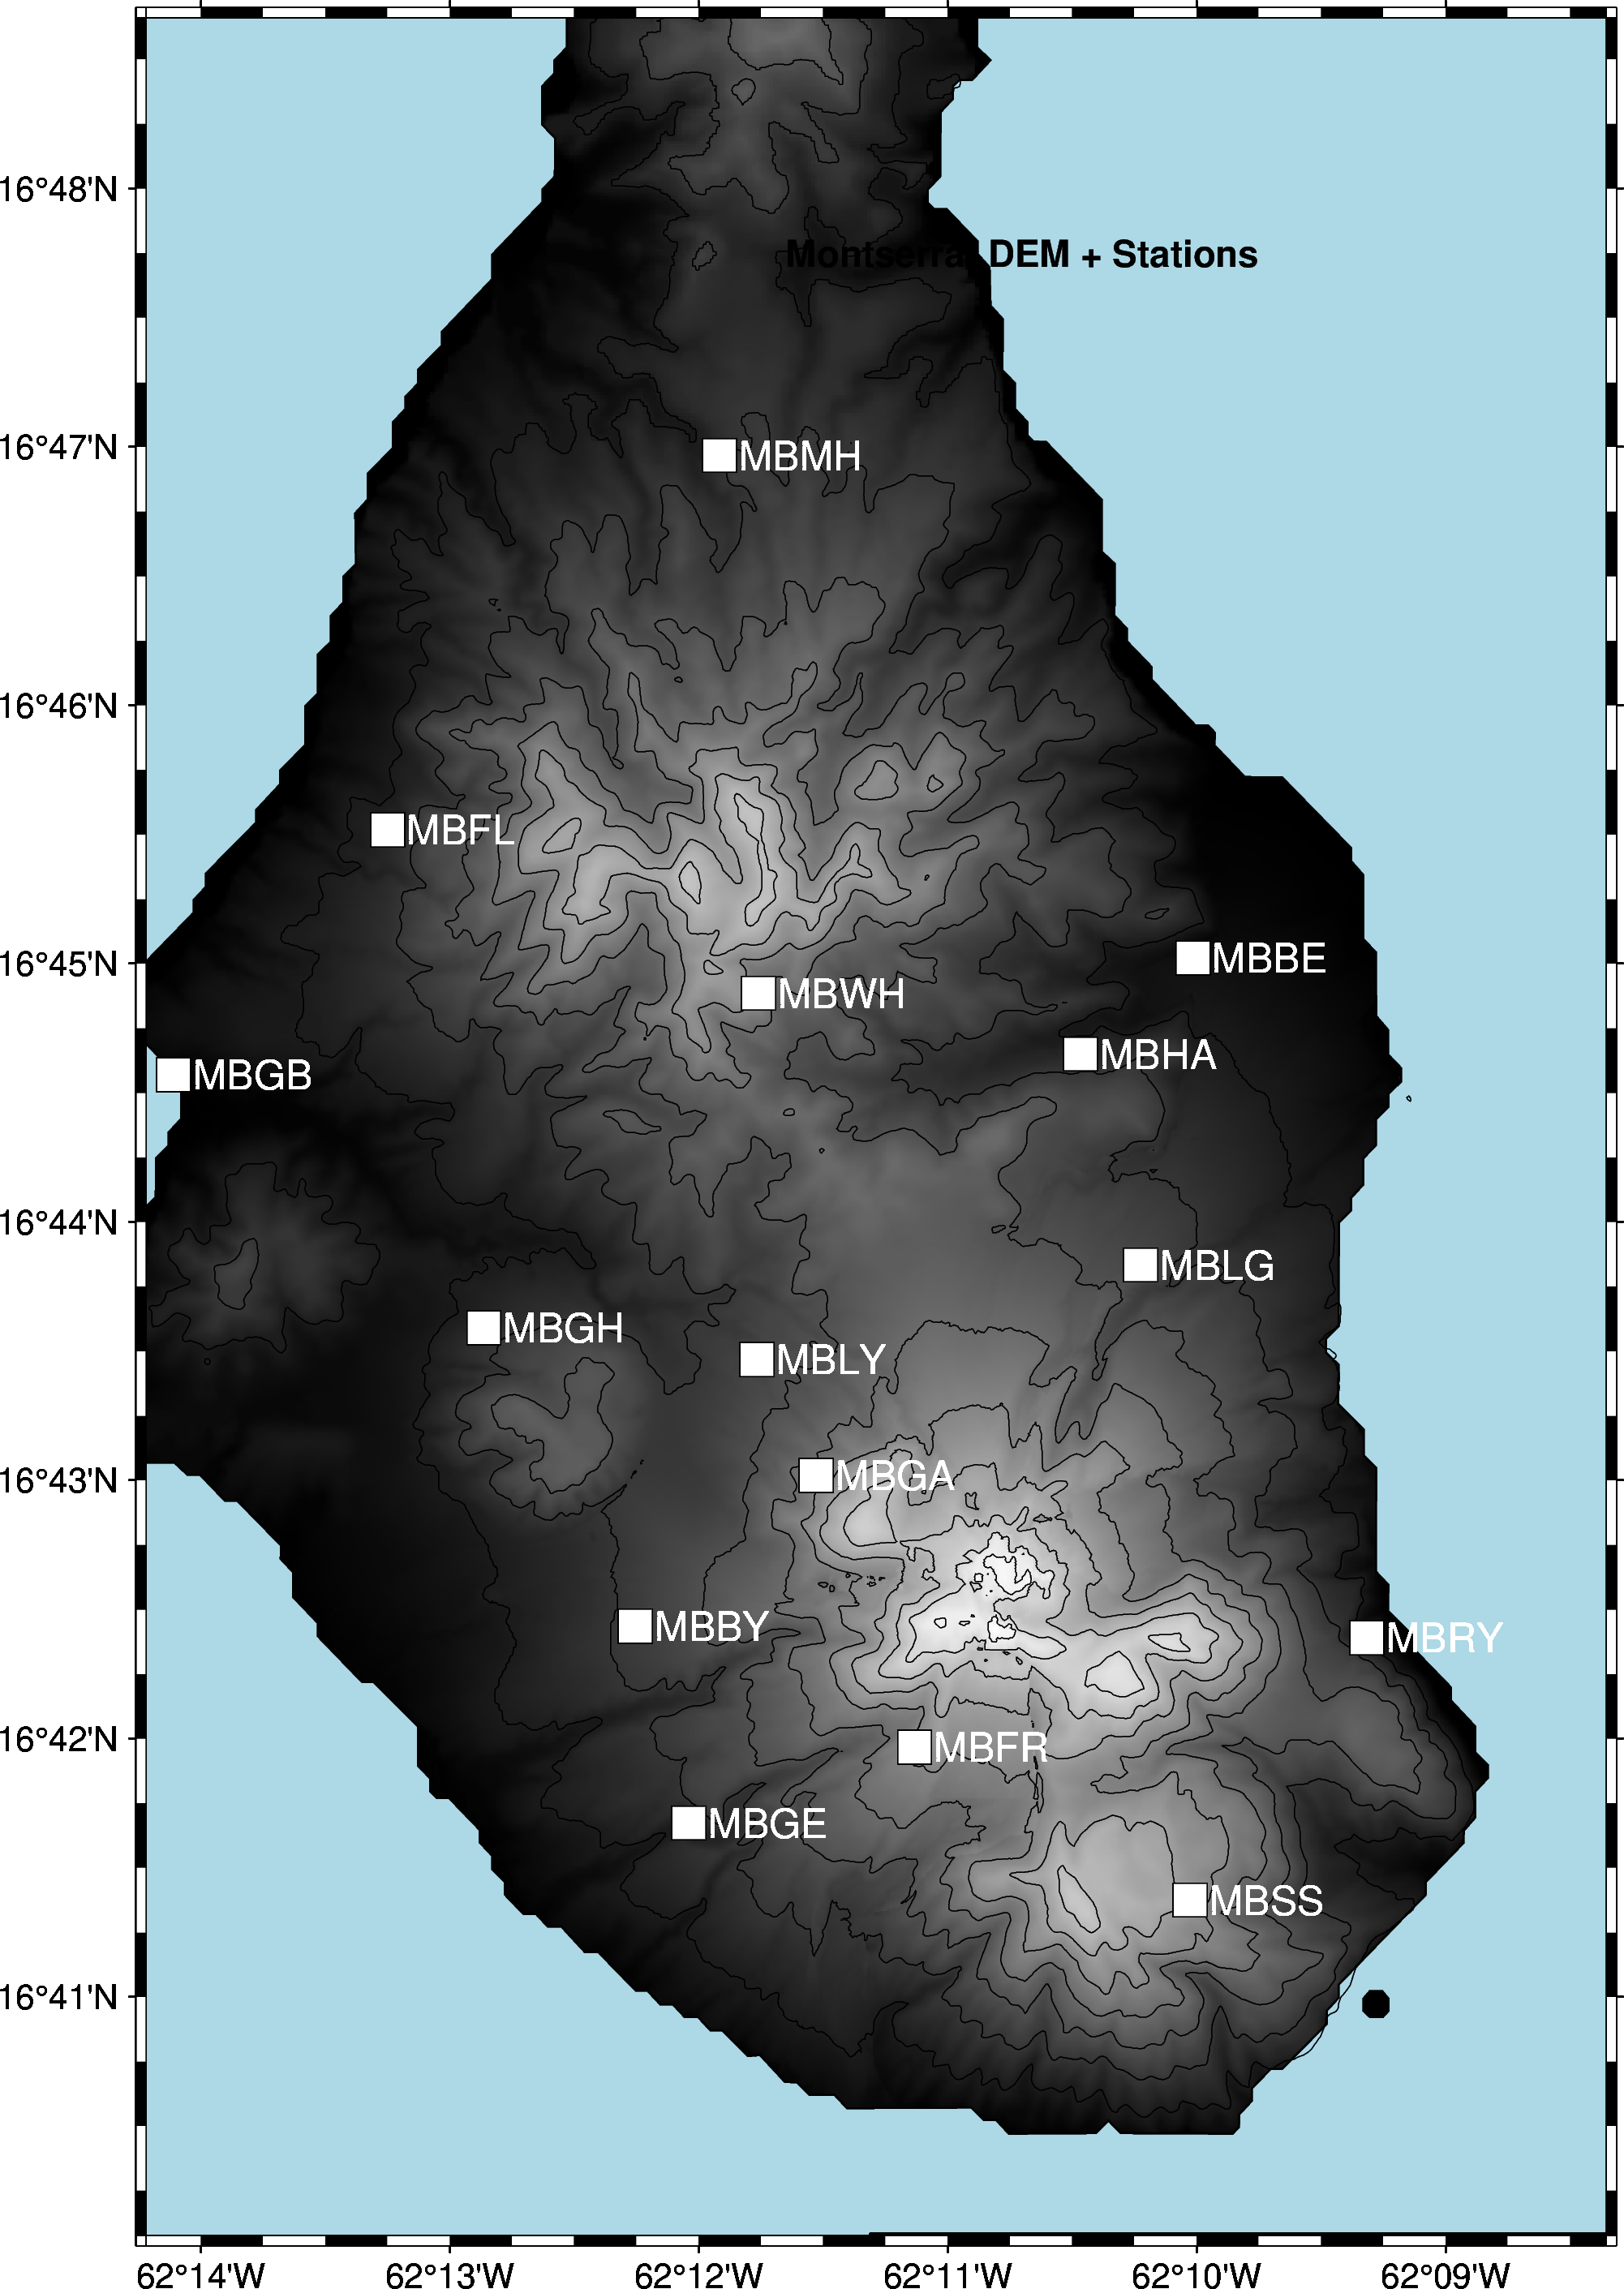

[PLOT] Saved → /Users/GlennThompson/work/PROJECTS/SSADenver_local/asl_global_cache/experiment_grid_10x15km_10m_mask7km_land.png


In [4]:

out_png = Path(OUTPUT_DIR) / "experiment_grid_10x15km_10m_mask7km_land.png"
out_png.parent.mkdir(parents=True, exist_ok=True)
grid.plot(show=False, topo_map_kwargs=topo_kw, outfile=str(out_png))
print(f"[PLOT] Saved → {out_png}")

In [5]:
grid.save(cache_dir = str(GLOBAL_CACHE), force_overwrite = False)

[INFO] Grid saved to /Users/GlennThompson/work/PROJECTS/SSADenver_local/asl_global_cache/Grid_530330bc.pkl


'/Users/GlennThompson/work/PROJECTS/SSADenver_local/asl_global_cache/Grid_530330bc.pkl'